<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/generate_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json,pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import load_model,Model
from PIL import Image 
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('fc2')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

In [ ]:
# Provide by @snsd0805
def preprocess_img(path):
  img = image.load_img(path, target_size=(224, 224))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features = encoder_model.predict(x)
  return features

In [ ]:
max_length = 30
start = '<start>'
end = '<end>'

# val_voc_10.pkl
* 內容包含: word_index 跟 inv_word_index
* 檔名的10代表取整個annotation的詞中出現次數超過10的詞彙
* 根據model使用的資料可能會需要不同的voc

In [ ]:
def generate_caption(model_path,img_path,show=True):
  p = open('/content/drive/MyDrive/MSCOCO_2017/val_voc_10.pkl','rb') # 根據model用的data，需更換VOC
  voc_data = pickle.load(p)
  word_index = voc_data['word_index']
  inv_word_index = voc_data['inv_word_index']
  voc_size = len(word_index) + 1

  decoder_model = load_model(model_path)
  img_data = preprocess_img(img_path)
  decoder_input = np.zeros((1,max_length),dtype='float32')
  token_cur = word_index[start]
  output_text = ''
  count_tokens = 0
  while token_cur != word_index[end] and count_tokens < max_length:
    decoder_input[0,count_tokens] = token_cur
    decoder_output = decoder_model.predict([img_data,decoder_input])
    token_cur = np.argmax(decoder_output[0,count_tokens]) 
    cur_word = inv_word_index[token_cur]
    if(cur_word != end):
      output_text += " " + cur_word
    count_tokens += 1
  if show:
    test_image = plt.imread(img_path)
    plt.imshow(test_image)
    plt.show()
    print("Caption:")
    print(output_text)
    return output_text
  else:
    return output_text

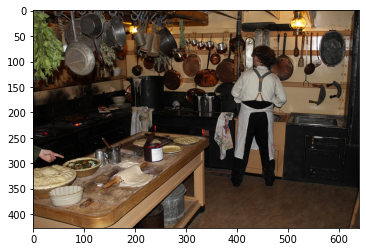

Caption:
 taken vegetables in of being near being displayed together together


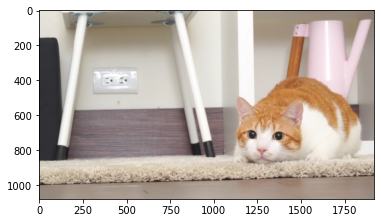

Caption:
 someone poses out toward a shaped like a bathroom


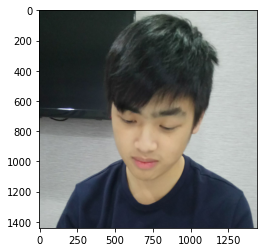

Caption:
 shaped each high in a kitchen with the


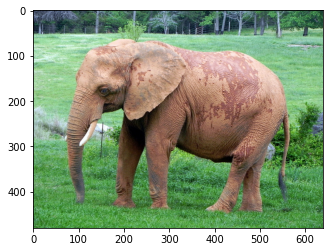

Caption:
 shaped white pillows with green plastic roll around each other around it


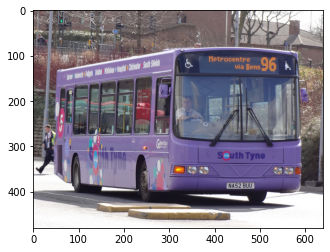

Caption:
 look up the back line sits on the side of a white road


' look up the back line sits on the side of a white road'

In [ ]:
#上方的所有code都要跑過
#只要更改你要用的model檔案位置跟你要caption的檔案位置就可以用了

model_path = '/content/drive/MyDrive/MSCOCO_2017/model_noatt25000data.h5'
generate_caption(model_path,'/content/drive/MyDrive/MSCOCO_2017/val2017/000000397133.jpg')
generate_caption(model_path,'/content/drive/MyDrive/eggroll.jpg')
generate_caption(model_path,'/content/drive/MyDrive/me.jpg')
generate_caption(model_path,'/content/drive/MyDrive/MSCOCO_2017/test2017/000000001371.jpg')
generate_caption(model_path,'/content/drive/MyDrive/MSCOCO_2017/val2017/000000002006.jpg')

# 評估模型準確度 Evaluate model
用來產生 BLEU, METEOR, ROUGE_L, CIDEr 分數

In [ ]:
# 取得不重複的 val 圖片檔名列表
val_anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(val_anno_path)
val_annotation = json.load(input_file)

id_list = set()
for cap in val_annotation['annotations']:
  id_list.add(cap['image_id'])

id_list = list(id_list)

In [ ]:
len(id_list)

5000

In [ ]:
# 產生所有 val 的 caption 預測結果並輸出成規定格式
# 評分資料格式在 https://cocodataset.org/#format-data 的 5. Image Captioning 大標下有規定
results = list()
for id in tqdm(range(len(id_list))):  # 多加個 tqdm 是為了看他印出漂亮的進度條
  one_result = dict()
  complete_path = img_path + '/%012d.jpg' % id_list[id]
  cap = Generate_caption(complete_path,show=False) # 把這裡替換成你用來生 caption 的 function
  one_result["image_id"] = id
  one_result["caption"] = cap
  results.append(one_result)



In [ ]:
len(results)

In [ ]:
# 輸出成 json 檔
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)

In [ ]:
# 產生假的完美結果，測試用
'''
answer_json = "/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json"
with open(answer_json, 'r') as f:
  answer = json.load(f)

added_caps = set()
results = list()
for cap in answer['annotations']:
  if cap['image_id'] not in added_caps:
    added_caps.add(cap['image_id'])
    one_result = dict()
    one_result["image_id"] = cap["image_id"]
    one_result["caption"] = cap["caption"]
    results.append(one_result)
  
generated_caption_path = "generated_caption_val2017.json"
with open(generated_caption_path, 'w') as jsonfile:
  json.dump(results, jsonfile)
'''

In [ ]:
def evaluate_coco(generated_json, answer_json):
  import os, sys
  if not os.path.exists('coco-caption'):
    # 下載相容 Python3 的非官方套件
    !git clone https://github.com/davidfsemedo/coco-caption
  sys.path.insert(0,"/content/coco-caption")
  from pycocotools.coco import COCO
  from pycocoevalcap.eval import COCOEvalCap
  import skimage.io as io
  import pylab
  pylab.rcParams['figure.figsize'] = (10.0, 8.0)

  from json import encoder
  encoder.FLOAT_REPR = lambda o: format(o, '.3f')

  # 繞過 val2017 和 2014 格式不同的 bug 
  # https://github.com/tylin/coco-caption/issues/26#issuecomment-439825144
  if (os.path.basename(answer_json) == "captions_val2017.json"):
    modified_anno_path = "/content/modified_captions_val2017.json"
    with open(answer_json, 'r') as f:
      data = json.load(f)
    data['type'] = 'captions'
    with open(modified_anno_path, 'w') as f:
      json.dump(data, f)
    answer_anno_path = modified_anno_path
  else:
    answer_anno_path = answer_json

  coco = COCO(answer_anno_path)
  cocoRes = coco.loadRes(generated_json)

  # create cocoEval object by taking coco and cocoRes
  cocoEval = COCOEvalCap(coco, cocoRes)

  # evaluate on a subset of images by setting
  # cocoEval.params['image_id'] = cocoRes.getImgIds()
  # please remove this line when evaluating the full validation set
  cocoEval.params['image_id'] = cocoRes.getImgIds()

  # evaluate results
  cocoEval.evaluate()

  # print output evaluation scores
  for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

In [ ]:
generated_json_path = "generated_caption_val2017.json"
answer_json_path = "/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json"
evaluate_coco(generated_caption_path, answer_json_path)

loading annotations into memory...
0:00:00.041497
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 28347, 'reflen': 27259, 'guess': [28347, 25652, 22957, 20262], 'correct': [11694, 2856, 710, 265]}
ratio: 1.0399134230895837
Bleu_1: 0.413
Bleu_2: 0.214
Bleu_3: 0.112
Bleu_4: 0.066
computing METEOR score...
METEOR: 0.104
computing Rouge score...
ROUGE_L: 0.320
computing CIDEr score...
CIDEr: 0.105
Bleu_1: 0.413
Bleu_2: 0.214
Bleu_3: 0.112
Bleu_4: 0.066
METEOR: 0.104
ROUGE_L: 0.320
CIDEr: 0.105
